In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go
import plotly.express as px
import cufflinks as cf

import ipywidgets as widgets
from ipywidgets import interact

cf.go_offline()
sns.set()

In [3]:
df_hmean = pd.read_csv("h_mean.csv.gz", index_col=0, header=[0,1])
df_fft = pd.read_parquet("fft.parquet.gzip", engine="pyarrow")
str_locs = df_fft.columns

In [4]:
df_fft_roll = pd.read_csv("fft_roll.csv.gz").set_index(["freq", "timestamp"])

# Hourly mean pressure

In [5]:
grid_dict = dict(showgrid=True, gridcolor="black", gridwidth=0.1, dtick=2.5)

geo_dict = dict(projection_type="natural earth", showcoastlines=False, showrivers=True, showframe=False,
                showcountries=True, countrycolor="white",
                showland=True, landcolor="#c2c2c2",
                showocean=True, oceancolor="#e6fcfc",
                showlakes=True, lakecolor="#3399FF",
                lonaxis=grid_dict, lataxis=grid_dict)

scatter_geo_layout = go.Layout(geo=geo_dict)

In [6]:
@interact

def show_hmean(loc=str_locs):
    
    title = f"Hourly mean pressure for location: {loc}"
    fig = df_hmean[loc].iplot(subplots=True, shape=(2,1), title=title, legend=False, asFigure=True)
    
    fig.layout["yaxis"]["title"]["text"] = "Pressure [mb]"
    fig.layout["yaxis2"]["title"]["text"] = "Count"
    fig.show()
    
    
    tup_loc = loc.split(",")
    fig = px.scatter_geo(lat=[tup_loc[0]], lon=[tup_loc[1]], size=[20])
    fig.update_layout(scatter_geo_layout)
    fig.show()    

interactive(children=(Dropdown(description='loc', options=('32.5,-120.0', '32.5,-97.5', '37.5,-122.5', '37.5,-…

# FFT results PSD plot

In [7]:
# chi 2 rv value for given ci
rv = stats.chi2(df=2)
chi95 = rv.ppf(0.95)
chi99 = rv.ppf(0.99)
chi999 = rv.ppf(0.999)

@interact
def show_fft(loc=str_locs, logy=True):

    # main plot
    fig = df_fft[loc].dropna().iplot(asFigure=True, logy=logy, xTitle="Freq [cpd]", yTitle="Normalized PSD", 
                                          color="Navy", title=f"Location: {loc}")
    # add horizontal line
    fig.add_trace(go.Scatter(x=[0, 12], y=[chi95, chi95], name="95% ci",
                             mode="lines", line=dict(color="Red",dash="dashdot")))
    
    fig.add_trace(go.Scatter(x=[0, 12], y=[chi99, chi99], name="99% ci",
                             mode="lines", line=dict(color="Orange",dash="dashdot")))
    
    fig.add_trace(go.Scatter(x=[0, 12], y=[chi999, chi999], name="99.9% ci",
                             mode="lines", line=dict(color="Green",dash="dashdot")))
    
    # layout
    if logy:
        fig.update_layout(go.Layout(yaxis=dict(range=[-2,3])))
    
    
    fig.update_layout(showlegend=True)
    fig.show()

interactive(children=(Dropdown(description='loc', options=('32.5,-120.0', '32.5,-97.5', '37.5,-122.5', '37.5,-…

# Rolling fft PSD heat map

In [8]:
z_slider = widgets.FloatRangeSlider(value=(0,2), min=-8, max=4, step=0.5)

@interact

def show_fft_roll(loc=str_locs, colorscale=["purples", "spectral", "ylgnbu", "ylorrd"], 
                  inverted_colorscale=True, color_range=z_slider):
    
    hm = df_fft_roll[loc].unstack(0).dropna()
    
    if inverted_colorscale:
        cs = f"-{colorscale}"
    else:
        cs = colorscale
    
    np.log10(hm).iplot(kind="heatmap", yTitle="Frequency [cpd]", 
                       title=f"Log 10 Nomralized PSD for location: {loc}", colorscale=cs, 
                       zmin=color_range[0], zmax=color_range[1])

interactive(children=(Dropdown(description='loc', options=('32.5,-120.0', '32.5,-97.5', '37.5,-122.5', '37.5,-…

# Null hypothesis: time series is random, white noise


The PSD of white noise (normally distributed, mean 0, std of 1) **after normalization** is approximately distributed like chi square distribution with 2 degrees of freedom.

Notations:

* s - time series, real numbers
* S - FFT of s, complex numbers
* Sr - real part of S, normally distributed around 0
* Si - imaginary part of S, normally distributed around 0


$$
PSD = Sr^2 + Si^2
$$


$$
Normalized PSD = (\frac{Sr}{std(Sr)})^2 + (\frac{Si}{std(Si)})^2
$$

In [9]:
def compute_fft(signal):
    
    """
    Compute real fft for signal with a sampling rate 24 samples per day.
    Returns a dataframe with complex numbers, amplitude and PSD
    """
    
    # compute real fft on centered hourly mean time series
    n = len(signal)
    spectra = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(n=n, d=(1/24))
    
    # compute normalized psd
    real = spectra.real
    imag = spectra.imag
    psd_norm = (real / real.std())**2 + (imag / imag.std())**2

    # compute amplitude and psd from the complex numbers and store in df and return it
    fft_data = {"complex": spectra, "real": real, "imag": imag, 
                "amp": np.abs(spectra), "psd": np.abs(spectra)**2, "psd_norm": psd_norm}
    
    return pd.DataFrame(data=fft_data, index=pd.Index(freq, name="freq"))

In [10]:
# generate random white noise and compute fft
white = pd.Series(np.random.normal(size=5000))
white_fft = compute_fft(white)

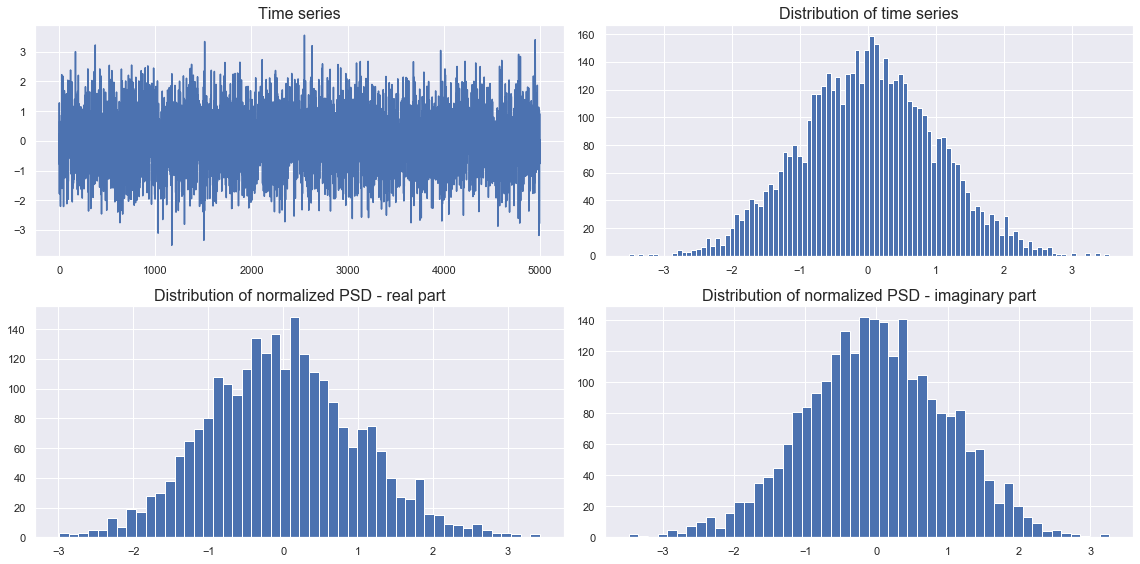

In [11]:
fig, axes = plt.subplots(2,2, figsize=(16,8))
ax = axes.ravel()


white.plot(ax=ax[0])
white.hist(bins=100, ax=ax[1])
(white_fft["real"] / white_fft["real"].std()).hist(bins=50, ax=ax[2])
(white_fft["imag"] / white_fft["imag"].std()).hist(bins=50, ax=ax[3])

# set titles
fs = 16
ax[0].set_title("Time series", fontsize=fs)
ax[1].set_title("Distribution of time series", fontsize=fs)
ax[2].set_title("Distribution of normalized PSD - real part", fontsize=fs)
ax[3].set_title("Distribution of normalized PSD - imaginary part", fontsize=fs)

plt.tight_layout()
plt.show()

$$
Normalized PSD = (\frac{Sr}{std(Sr)})^2 + (\frac{Si}{std(Si)})^2
$$

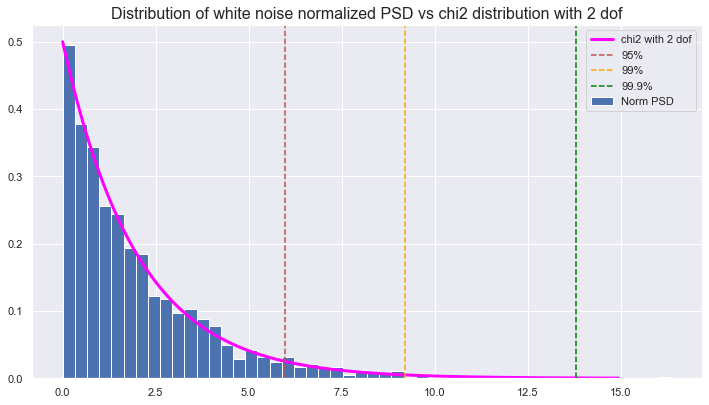

In [12]:
# plot dist of white normalized psd 
white_fft["psd_norm"].hist(bins=50, density=True, figsize=(12,6.5), label="Norm PSD")

# plot chi square dist with 2 dof
x = np.arange(0, 15, 0.05)
plt.plot(x, rv.pdf(x), color="magenta", lw=3, label="chi2 with 2 dof")

# plot confidence intervals
plt.axvline(chi95, color="r", linestyle="dashed", label="95%")
plt.axvline(chi99, color="orange", linestyle="dashed", label="99%")
plt.axvline(chi999, color="green", linestyle="dashed", label="99.9%")


plt.title("Distribution of white noise normalized PSD vs chi2 distribution with 2 dof", fontsize=16)
plt.legend(loc="upper right")


plt.show()

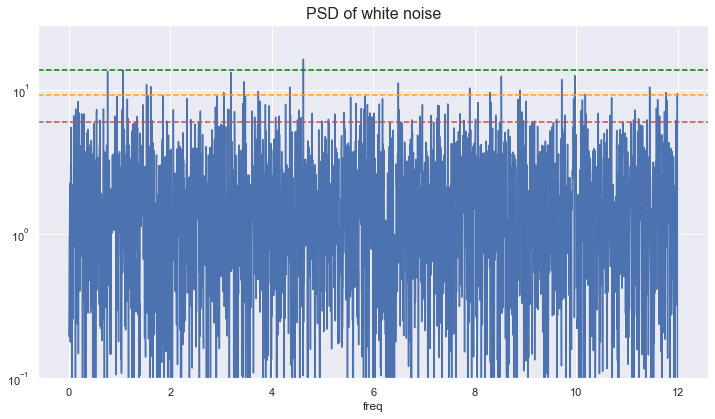

In [13]:
white_fft["psd_norm"].plot(logy=True, figsize=(12,6.5))

plt.axhline(chi95, color="r", linestyle="dashed", label="95%")
plt.axhline(chi99, color="orange", linestyle="dashed", label="99%")
plt.axhline(chi999, color="green", linestyle="dashed", label="99.9%")

# ax2.set_xlabel("Freq [cpd]")
# ax2.set_ylabel("PSD")
plt.ylim(bottom=0.1)
plt.title(label="PSD of white noise", fontsize=16)

plt.show()